In [1]:
import copy

from PIL import Image
import numpy as np
import tqdm

In [2]:
def open_convert_img(image_path):
    """Read and convert to gray-scale image
    """
    img = Image.open(image_path)
    img = np.array(img.convert("L"),dtype=np.int16)
    return img


def calculate_function_g(d1,d2,norm="L1"):
    """Args:
    d1,d2 : int in [0,...,maxD]
    norm : str defines norm either "L1" or "L2"
    Returns:
    diff : int corresponding to notm
    """
    if norm == "L1":
        return np.abs(d1-d2)
    if norm == "L2":
        return (d1-d2)**2
    raise ValueError("Incorrect argument 'norm' in calculate_function_g")
    
    
def calculate_function_H(current_index, d, left_line, right_line, norm="L1"):
    """Args:
    current_index : int in [0,..,m]
    d: int in [0,...,maxD]
    left_line : 1-d array represneting a row from left image
    right_line : 1-d array represneting a row from right image(corresponde to left_line)
    norm : str defines norm either "L1" or "L2"
    Returns:
        diff : int16
    """
    if (current_index - d) < 0:
        return float("inf")
    else :
        diff = left_line[current_index] - right_line[current_index - d]
        if norm == "L1":
            return np.abs(diff)
        if norm == "L2":
            return np.sqrt((diff)**2)
        raise ValueError("Incorrect argument 'norm' in 'calculate_function_H'")


def calculate_f_step_0(set_D,left_line,right_line):
    """Calculate f0 (due to seminar's notion)
    Args:
        set_D : ordered numpy array (e.g. [0,1,2,...,maxD])
        left_line : 1-d array represneting a row from left image
        right_line : 1-d array represneting a row from right image(corresponde to left_line)
    Returns:
        f0_list : list of f0(d) , d є set_D
        s_list :  list of lists
    """
    f0_list = list()
    s_list = list()
    for d in set_D:
        current_node = calculate_function_H(0,d,left_line,right_line,"L1")
        f0_list.append(current_node)
        s_list.append([0])
    return f0_list, s_list

def find_best_d_prev_for_d_next(index_next,d_next,set_D, f_previous_list, left_line,right_line, verteces, alpha=50):
    """For a given d_next and step i, find fi(d_next) (due to seminar's notion)
    Args:
        index_next : int argument, respreseing an index of pixel
        d_next : int, d from set_D, which we're finding a minimum value of f to
        set_D : ordered numpy array (e.g. [0,1,2,...,maxD])
        f_previous_list : list of values of f for previous step 
        left_line : 1-d array represneting a row from left image
        right_line : 1-d array represneting a row from right image(corresponde to left_line)
    Return:
        min_value : int
        min_argumnet : int from set_D
    """
    min_value = float("inf")
    min_argument = None
    for d_previous in set_D:
        next_value = f_previous_list[d_previous] + alpha*verteces[d_previous,d_next]
        if next_value < min_value:
            min_value = next_value
            min_argument = d_previous
    min_value += calculate_function_H(index_next, d_next, left_line, right_line,"L1")
    return min_value, min_argument


def calculate_f_next(index_next, set_D, f_previous_list,s_previous_list, left_line, right_line, verteces):
    """Using 'find_best_d_prev_for_d_next' , find fi(d) , for each d є set_D.
    Args:
        index_next : int argument, respreseing an index of pixel
        set_D : ordered numpy array (e.g. [0,1,2,...,maxD])
        f_previous_list : list of values of f for previous step 
        left_line : 1-d array represneting a row from left image
        right_line : 1-d array represneting a row from right image(corresponde to left_line)
    Return:
        f_next_list : list of f_next_list(d) , d є set_D
    """
    f_next_list = list()
    for d in set_D:
        next_value, next_d = find_best_d_prev_for_d_next(index_next,d,set_D, f_previous_list, left_line, right_line, verteces)
        f_next_list.append(next_value)
        s_previous_list[d].append(next_d)
    return f_next_list

def precompute_verteces(set_D, norm="L1"):
    verteces = np.zeros((set_D.shape[0],set_D.shape[0]))
    for d_i in set_D:
        for d_j in set_D:
            verteces[d_i,d_j] = calculate_function_g(d_i, d_j, norm)
    return verteces

In [3]:
image_path1 = "./cones/im2.png"
image_path2 = "./cones/im6.png"
# read images
img1 = open_convert_img(image_path1)
img2 = open_convert_img(image_path2)
print("Shape of image1 : ",img1.shape)
print("Shape of image2 : ",img2.shape)

Shape of image1 :  (375, 450)
Shape of image2 :  (375, 450)


In [4]:
D = np.arange(64)
print("D : ", D)
print("image_width : ", img1.shape[1])
print("image_height : ", img1.shape[0])

list_sequences = list()
verteces = precompute_verteces(D)
# loop through ten random rows from an image
for i in tqdm.tqdm(np.random.choice(img1.shape[0],10)):
    line_left = img1[i,:]
    line_right = img2[i,:]
    # loop through row
    for j in range(0,img1.shape[0]):
        if j == 0:
            # 'f_current' - list of size = len(D), calculated for current index j (due to seminar's notation)
            # 's_list' - list of len(D) lists, each element of list is a sequence of d's
            f_current, s_list = calculate_f_step_0(D,line_left,line_right)
        else:
            # change 's_list' inside of the function
            f_current = calculate_f_next(j, D, f_current, s_list, line_left, line_right, verteces)
    # find d, which minimizes f(maxD)
    argmin_d = np.argmin(np.array(f_current))
    # sequence of d's, corresponding to above-defined 'argmin_d'
    list_sequences.append(copy.deepcopy(s_list[argmin_d]))
    del f_current, s_list

D :  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
image_width :  450
image_height :  375


100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


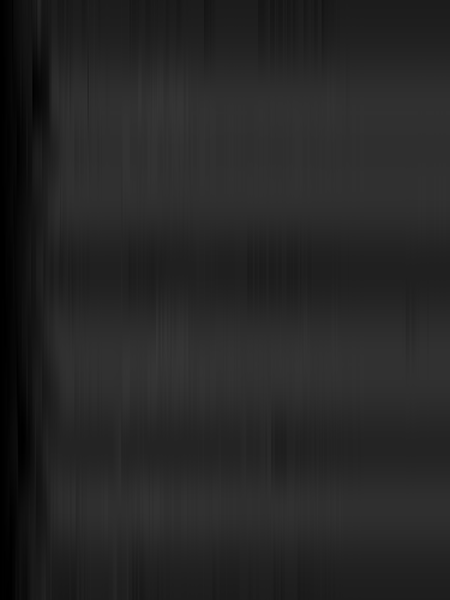

In [9]:
Image.fromarray(np.uint8(np.array(list_sequences))).resize((450,600), Image.ANTIALIAS)